# Analysis of Reaction Times

## Objective
The goal is not only to perform behavioral analysis, but also to understand the data better.

---

## Notebook Workflow

### 1. Load and Preprocess Data
- Compute `reaction_time` = `time_targ_acq - time_FP_off`
- Compute `go_time` = `time_FP_off - time_target_on`
- Filter trials with valid timestamps

### 2. Visualize Reaction Times
- Plot **reaction time vs go_time** for both sessions
- Overlay smoothed RT curves using Gaussian filtering
- Annotate the ketamine **onset and wash-off points** based on data-driven detection

### 3. Compare RT Distributions
- Use KDE plots to compare the full distribution of RTs
- Statistical t-test for mean RT difference
- Compare trial-to-trial variability

### 4. Fit Reaction Time Models
- Fit **Weibull-based subjective hazard functions** to both sessions:
- Plot:
    - Smoothed RT (purple line)
    - Fitted anticipation curve (black)
    - Dashed purple curve = subjective hazard function

### 5. Identify Ketamine Phases (Onset, Active, Wash-off)
- Use gradients of smoothed RT to **detect change-points**
- Segment trials by `go_time`:
    - **Pre-Ketamine Phase**
    - **Ketamine Active Phase**
    - **Wash-Off Phase**
- Plot RT over `go_time` with shaded regions for interpretation

---

## Theoretical Understanding

- **Ketamine disrupts internal timing**: Under NMDA receptor blockade, the brain cannot generate or maintain the **subjective anticipation function** (hazard rate).
- **Decreased anticipation gain** and **delayed RT response** reflect impaired neural integration of elapsed time.
- **Temporal ramping signals** in PFC/LIP are likely disrupted, leading to noisier and less precise action planning.
- The **recovery** of behavior after `go_time ≈ 1.75s` supports that ketamine has a short half-life.

---

## Summary

This analysis combines:
- Behavioral measurements
- Statistical testing
- Subjective hazard modeling (computational timing)
- Phase segmentation based on RT changes

In [30]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
file_path = '20140925_Ketamine02/Charlie_20140925_master_AnticipSacc_behavior.mat'
data = loadmat(file_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'eMat'])


In [31]:
file_path_ = 'timeData.mat/timeData.mat'
columns = loadmat(file_path_)
columnnames = columns['columnNames']

In [32]:
data['eMat'].shape

(953, 42)

In [33]:
df_n = pd.read_csv("Sample_200.csv")

In [34]:
column_names = [name for name in columns['columnNames'].dtype.names]
trial_data = data['eMat']
df = pd.DataFrame(trial_data, columns=column_names[:trial_data.shape[1]])

In [35]:
df.dropna(axis=1, how='all')

,monkeyID,fileID,trial_type,target1_x,target1_y,dot_duration,fixation_x,fixation_y,time_FP_on,time_target_on,time_target_off,time_FP_off,time_targ_acq,time_reward,time_end
0,2097.0,1001.0,19.0,9.51296,5.48394,1413.333333,0.0,0.0,62.709800,63.377350,63.671000,NaN,NaN,NaN,NaN
1,2097.0,1002.0,19.0,9.51296,-5.48394,733.333333,0.0,0.0,67.742525,68.424200,68.717200,69.491325,69.865175,69.985225,70.078700
2,2097.0,1003.0,19.0,11.00520,0.00000,1560.000000,0.0,0.0,71.240075,71.867675,72.161350,NaN,NaN,NaN,NaN
3,2097.0,1004.0,19.0,11.00520,0.00000,NaN,0.0,0.0,76.900300,77.661275,NaN,NaN,NaN,NaN,NaN
4,2097.0,1005.0,19.0,9.51296,5.48394,1306.666667,0.0,0.0,79.062975,79.783875,80.077525,81.425825,81.826275,81.946425,82.039900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2097.0,3224.0,19.0,9.51296,5.48394,1253.333333,0.0,0.0,3915.762350,3917.003800,3917.297575,3918.592475,3918.952875,3919.072950,3919.166475
949,2097.0,3225.0,19.0,11.00520,0.00000,973.333333,0.0,0.0,3920.327850,3921.035425,3921.329075,3922.343675,3922.690725,3922.810825,3922.904275
950,2097.0,3226.0,19.0,11.00520,0.00000,880.000000,0.0,0.0,3924.065700,3924.973525,3925.267200,3926.188275,3926.548725,3926.668900,3926.762350
951,2097.0,3227.0,19.0,5.52125,9.51296,906.666667,0.0,0.0,3927.923725,3928.938275,3929.232075,NaN,NaN,NaN,NaN


In [36]:
df["reaction_time"] = df["time_targ_acq"] - df["time_FP_off"]
df["go_time"] = df["time_FP_off"] - df["time_target_on"]

In [37]:
df = df[df["reaction_time"].notna() & df["go_time"].notna()]

In [42]:
df_n = df_n[df_n["reaction_time"].notna() & df_n["go_time"].notna()]

In [99]:
df_n.index

RangeIndex(start=0, stop=161, step=1)

In [101]:
df.reset_index(drop=True, inplace=True)

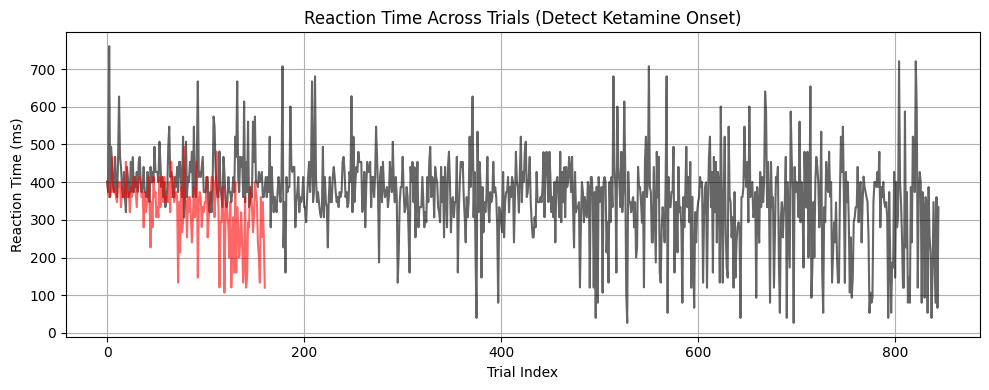

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["reaction_time"] * 1000, linestyle='-', color='black', alpha=0.6)
plt.plot(df_n.index, df_n["reaction_time"] * 1000, linestyle='-', color='red', alpha=0.6)
plt.xlabel("Trial Index")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time Across Trials (Detect Ketamine Onset)")
plt.grid(True)
plt.tight_layout()
plt.show()

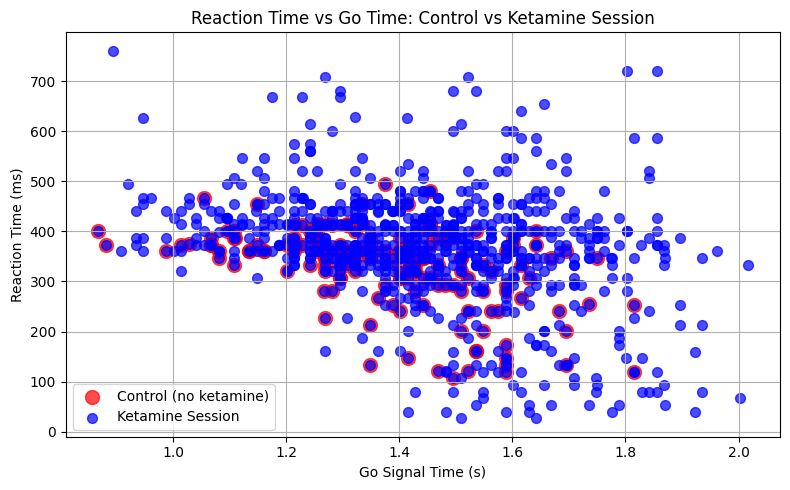

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(df_n["go_time"], df_n["reaction_time"] * 1000,
            color="red", alpha=0.7, label="Control (no ketamine)", s=100)

plt.scatter(df["go_time"], df["reaction_time"] * 1000,
            color="blue", alpha=0.7, label="Ketamine Session", s=50)

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time: Control vs Ketamine Session")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

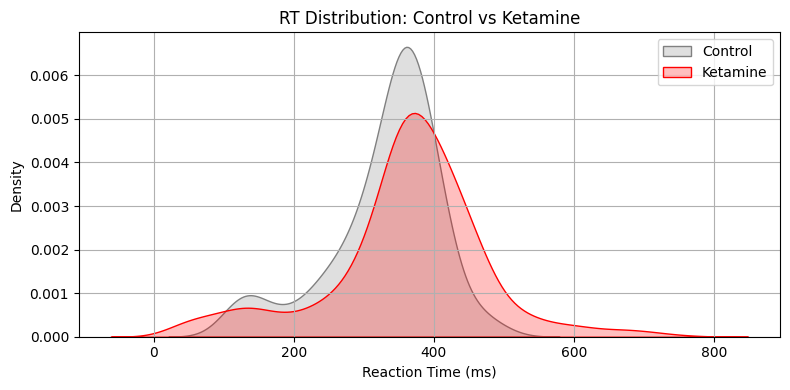

In [44]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_n["reaction_time"] * 1000,
            label="Control", fill=True, color="gray")
sns.kdeplot(df["reaction_time"] * 1000,
            label="Ketamine", fill=True, color="red")
plt.xlabel("Reaction Time (ms)")
plt.title("RT Distribution: Control vs Ketamine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    df_n["reaction_time"], df["reaction_time"], equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.3e}")

T-test: t = -4.25, p = 2.853e-05


In [47]:
df["reaction_time_ms"] = df["reaction_time"] * 1000
df["rolling_rt"] = df["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [61]:
df_n["reaction_time_ms"] = df_n["reaction_time"] * 1000
df_n["rolling_rt"] = df_n["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [67]:
df.reset_index(drop=True, inplace=True)

In [72]:
df_n.shape, df.shape

((161, 46), (845, 46))

In [97]:
df_n.sort_values("go_time", inplace=True)
df.sort_values("go_time", inplace=True)
df_n.reset_index(drop=True, inplace=True)

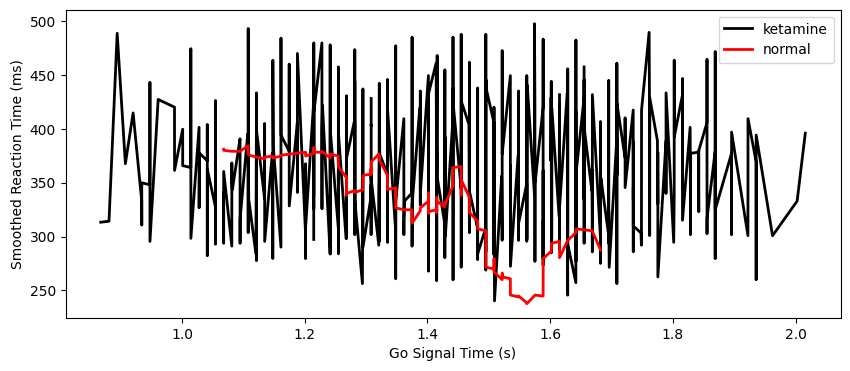

In [83]:
plt.figure(figsize=(10, 4))

plt.plot(df.go_time, df["rolling_rt"],
         color='black', linewidth=2, label="ketamine")

plt.plot(df_n.go_time, df_n["rolling_rt"],
         color='red', linewidth=2, label="normal")
plt.xlabel("Go Signal Time (s)")
plt.ylabel("Smoothed Reaction Time (ms)")
plt.legend()

In [ ]:
from scipy.stats import weibull_min, norm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [54]:
def blurred_weibull_hazard(t_array, alpha, beta, delay, phi=0.26):
    t_eval = np.linspace(0.5, 2.0, 1000)
    t_adj = np.clip(t_eval - delay, 1e-3, None)
    f = weibull_min.pdf(t_adj, beta, scale=1 / alpha)

    blurred = np.zeros_like(t_eval)
    for i, t in enumerate(t_eval):
        sigma = phi * t
        kernel = norm.pdf(t - t_eval, scale=sigma)
        kernel /= kernel.sum()
        blurred[i] = np.sum(f * kernel)

    F_blurred = np.cumsum(blurred) * (t_eval[1] - t_eval[0])
    hazard = blurred / (1 - F_blurred + 1e-8)
    return np.interp(t_array, t_eval, hazard / np.max(hazard))  

In [56]:
def rt_model(t, baseline, weight, alpha, beta, delay):
    h = blurred_weibull_hazard(t, alpha, beta, delay)
    return baseline - weight * h

In [59]:
def plot_fit(df_input, title, ax):
    df_input = df_input.copy()
    df_input["reaction_time"] = df_input["time_targ_acq"] - \
        df_input["time_FP_off"]
    df_input["go_time"] = df_input["time_FP_off"] - df_input["time_target_on"]
    df_input = df_input[df_input["reaction_time"].notna() &
                        df_input["go_time"].notna()].copy()
    df_input["reaction_time_ms"] = df_input["reaction_time"] * 1000
    df_input.sort_values("go_time", inplace=True)

    x = df_input["go_time"].values
    y = df_input["reaction_time_ms"].values
    p0 = [300, 100, 1.0, 3.0, 0.5]
    popt, _ = curve_fit(rt_model, x, y, p0=p0, maxfev=20000)

    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = rt_model(x_fit, *popt)
    smoothed_rt = gaussian_filter1d(y, sigma=1)
    ax.plot(x, smoothed_rt, color='purple', lw=2.5, label="Smoothed RT")
    ax.plot(x_fit, y_fit, color='black', lw=2, label="Model Fit")
    anticipation = blurred_weibull_hazard(x_fit, *popt[2:])
    anticipation_scaled = anticipation * max(y) * 0.8
    ax.plot(x_fit, anticipation_scaled, '--', color='purple',
            lw=2, label="Anticipation Function")

    ax.set_title(title)
    ax.set_xlabel("Go Time (s)")
    ax.set_ylabel("Reaction Time (ms)")
    ax.grid(True)
    ax.legend(frameon=False)

    return popt

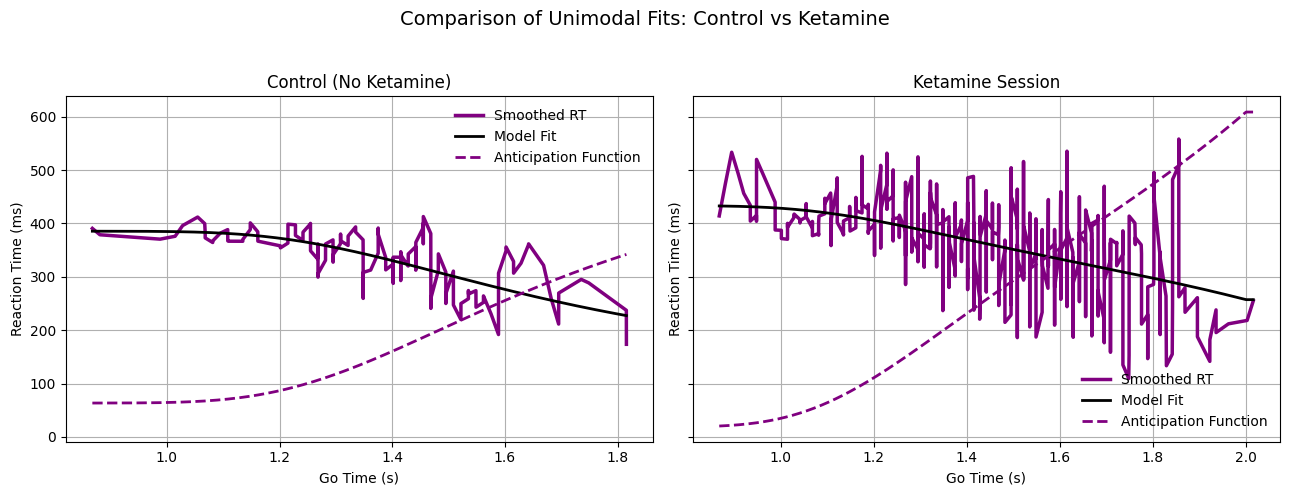

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

popt_control = plot_fit(df_n.copy(), "Control (No Ketamine)", axs[0])
popt_ketamine = plot_fit(df.copy(), "Ketamine Session", axs[1])

plt.suptitle("Comparison of Unimodal Fits: Control vs Ketamine", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [84]:
smoothed_rt = gaussian_filter1d(df["reaction_time_ms"], sigma=5)

In [85]:
delta_rt = np.gradient(smoothed_rt)
onset_idx = np.argmax(delta_rt)  
wear_off_idx = np.argmin(delta_rt[onset_idx+10:]) + onset_idx + 10
onset_go = df.loc[onset_idx, "go_time"]
wear_off_go = df.loc[wear_off_idx, "go_time"]

print(f"Estimated Ketamine ONSET at go_time = {onset_go:.2f}s")
print(f"Estimated Ketamine WEAR-OFF at go_time = {wear_off_go:.2f}s")

Estimated Ketamine ONSET at go_time = 1.43s
Estimated Ketamine WEAR-OFF at go_time = 1.66s


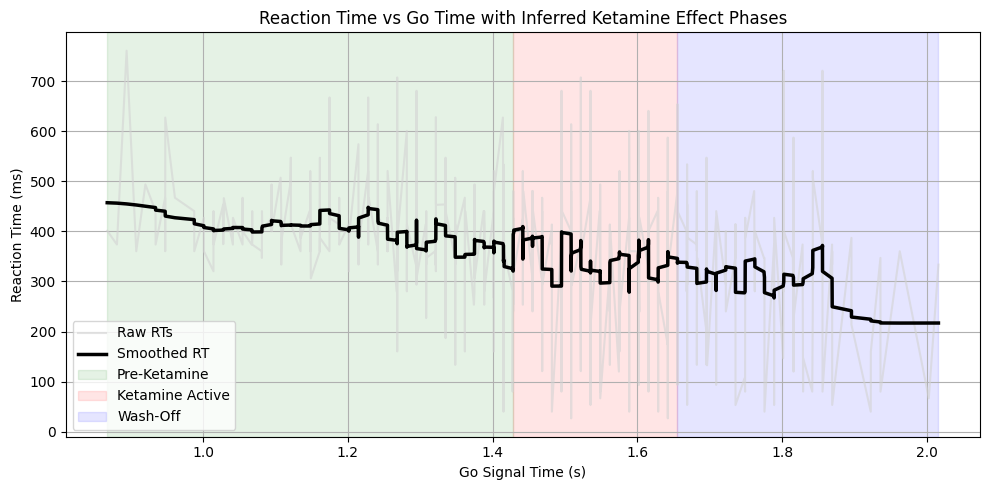

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(df["go_time"], df["reaction_time_ms"],
         color='lightgray', label="Raw RTs", alpha=0.6)
plt.plot(df["go_time"], smoothed_rt,
         color='black', lw=2.5, label="Smoothed RT")

plt.axvspan(df["go_time"].min(), onset_go,
            color='green', alpha=0.1, label="Pre-Ketamine")
plt.axvspan(onset_go, wear_off_go, color='red',
            alpha=0.1, label="Ketamine Active")
plt.axvspan(wear_off_go, df["go_time"].max(),
            color='blue', alpha=0.1, label="Wash-Off")

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time with Inferred Ketamine Effect Phases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
rt_control_smooth = gaussian_filter1d(df_n["reaction_time_ms"], sigma=5)
rt_ket_smooth = gaussian_filter1d(df["reaction_time_ms"], sigma=5)

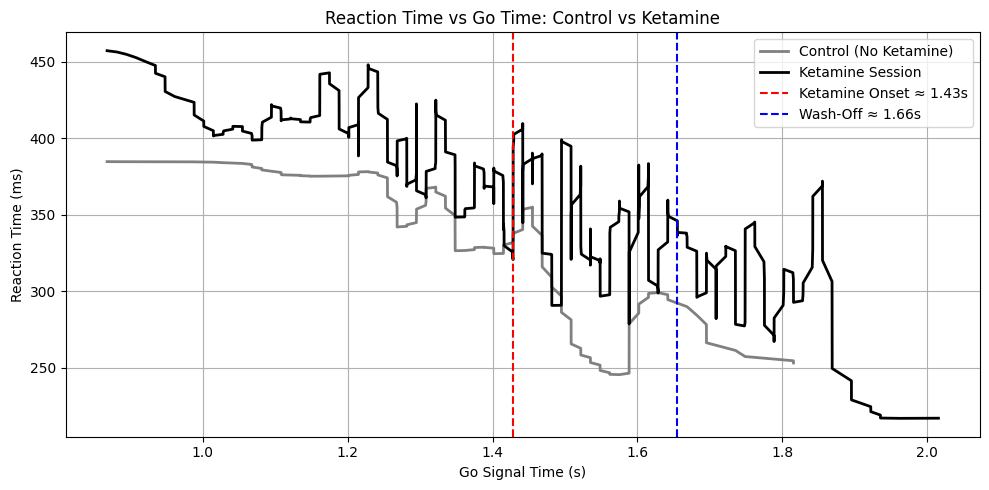

In [89]:
plt.figure(figsize=(10, 5))

plt.plot(df_n["go_time"], rt_control_smooth,
         color="gray", lw=2, label="Control (No Ketamine)")
plt.plot(df["go_time"], rt_ket_smooth,
         color="black", lw=2, label="Ketamine Session")

plt.axvline(onset_go, color="red", linestyle="--",
            label=f"Ketamine Onset ≈ {onset_go:.2f}s")
plt.axvline(wear_off_go, color="blue", linestyle="--",
            label=f"Wash-Off ≈ {wear_off_go:.2f}s")

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time: Control vs Ketamine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
df['go_time'].max(), df_n['go_time'].max()

(2.0157500000000255, 1.8156000000000176)